# Simple Object Detection & Segmentation with CLIP

In [1]:
import os
import requests
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
from transformers import CLIPProcessor, CLIPModel

## Data

In [2]:
def load_img(url):
    img_data = requests.get(url).content
    ftype = url.split('.')[-1]
    with open(f'tmp.{ftype}', 'wb') as f:
        f.write(img_data)
    img = torchvision.io.read_image(f'tmp.{ftype}')
    os.remove(f'tmp.{ftype}')
    return img

In [3]:
img = load_img('https://cdn.britannica.com/88/95288-050-BED911A4/Grizzly-bear-salmon-Katmai-National-Park-and.jpg')

In [4]:
# Make sure img has shape (channels, y_dim, x_dim)!!!
img.shape

torch.Size([3, 1072, 1600])

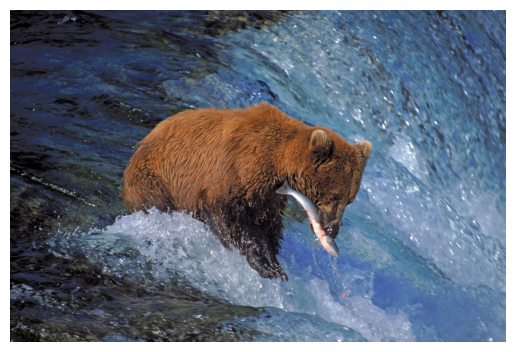

In [5]:
def imshow(img):
    show = img.cpu()
    if img.ndim == 3:
        show = show.permute(1,2,0)
    plt.axis('off')
    plt.margins(0)
    plt.imshow(show)
    plt.show()

imshow(img)

## Window Slices

In [6]:
def make_windows(img: torch.Tensor,
                 y_size: int, y_step: int,
                 x_size: int, x_step: int) -> tuple[torch.Tensor, tuple[slice]]:

    channels, y_dim, x_dim = img.shape

    # Unfold image into shape (channels, n_y, n_x, y_size, x_size)
    unfolded = img.unfold(1, y_size, y_step).unfold(2, x_size, x_step)

    # Permute image into shape (n_y, n_x, channels, y_size, x_size)
    permuted = unfolded.permute(1, 2, 0, 3, 4)

    # Combine (n_y, n_x) into one batch dimension. y-dimension takes precedence.
    batch = permuted.reshape(-1, channels, y_size, x_size)

    # Generate corresponding sequence of slices that represents where each window is extracted from.
    slices = [(slice(y+1-y_size, y+1, None), slice(x+1-x_size, x+1, None))
              for y in range(y_size-1, y_dim, y_step)
              for x in range(x_size-1, x_dim, x_step)]

    return batch, slices

In [7]:
windows, slices = make_windows(img, 256, 128, 128, 64)
windows.shape

torch.Size([168, 3, 256, 128])

Patch 22


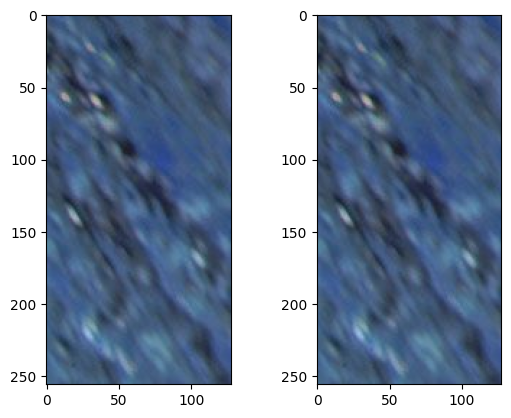

Patch 23


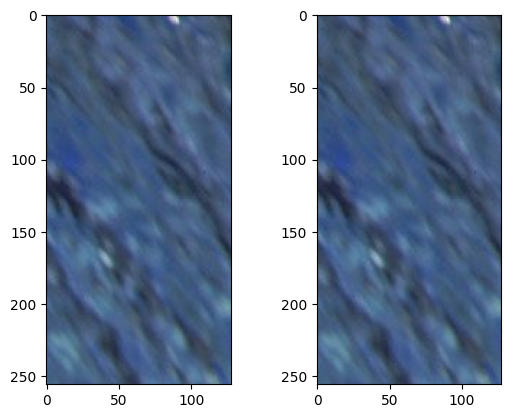

Patch 24


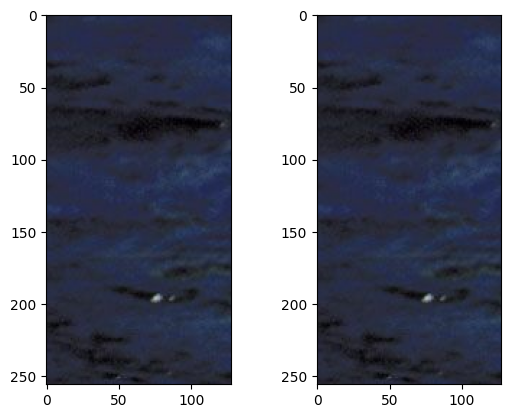

Patch 100


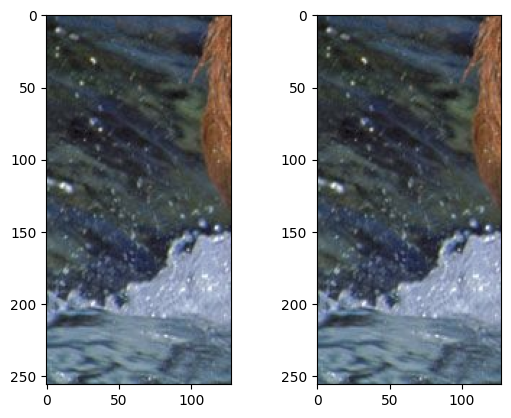

Patch 150


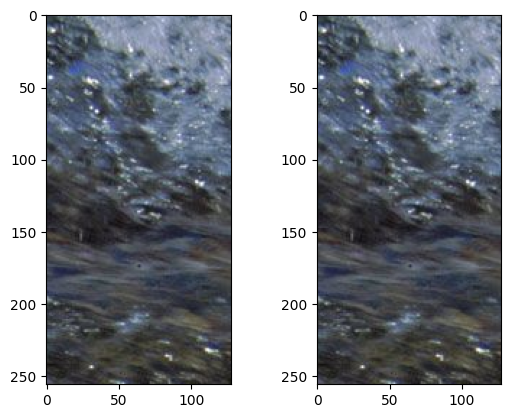

Patch 167


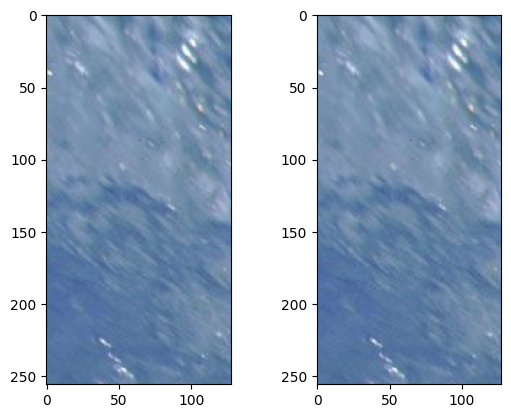

In [8]:
channel_last = img.permute(1,2,0)

for i in (22, 23, 24, 100, 150, 167):
    print(f'Patch {i}')
    f, ax = plt.subplots(1, 2)

    ax[0].imshow(windows[i].permute(1,2,0))
    ax[1].imshow(channel_last[slices[i]])

    plt.show()

## CLIP Heatmap

In [ ]:
model_id = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

In [30]:
def autotune_size_step(y_dim: int,
                       x_dim: int) -> tuple[tuple[int, int],
                                            tuple[int, int]]:
    s_dim = min(y_dim, x_dim)
    l_dim = max(y_dim, x_dim)
    size = l_dim // 6
    step = s_dim // 14
    return ((size, step), (size, step))

In [42]:
def CLIP_segment(img: torch.Tensor,
                 text: str,
                 model: CLIPModel = model,
                 processor: CLIPProcessor = processor,
                 threshold: float = 0.4,
                 temperature: float = 2.0,
                 y_size: int = None, y_step: int = None,
                 x_size: int = None, x_step: int = None,
                 batch_sz: int = 256,
                 device: str = device
                 ) -> torch.Tensor:

    _, y_dim, x_dim = img.shape

    if y_size is None or y_step is None:
        (y_size, y_step), _ = autotune_size_step(y_dim=y_dim,
                                                 x_dim=x_dim)

    if x_size is None or x_step is None:
        _, (x_size, x_step) = autotune_size_step(y_dim=y_dim,
                                                 x_dim=x_dim)

    windows, slices = make_windows(img,
                                   y_size=y_size, y_step=y_step,
                                   x_size=x_size, x_step=x_step)

    # Calculate scores for each batch of patches
    scores = []
    for batch_start in tqdm(range(0, len(windows), batch_sz)):
        inp = processor(
            images=windows[batch_start:batch_start+batch_sz],
            return_tensors="pt",
            text=text,
            padding=True
        ).to(device)
        with torch.no_grad():
            out = model(**inp).logits_per_image
        scores.append(out.flatten())

    # Remove batch dimensions, concat scores into 1D array
    scores = torch.cat(scores)

    # Rejiggle and softmax
    scores = ((scores-scores.mean()) / temperature).softmax(dim=0)

    # Initialise heatmap and frequencies in same shape as img, with 0s everywhere
    heatmap = torch.zeros(img.shape[1:]).to(device)
    frequency = torch.zeros(img.shape[1:]).to(device)

    # Update heatmap and frequency
    for score, loc in zip(scores, slices):
        heatmap[loc] += score
        frequency[loc] += 1

    # Average heatmap across CLIP-scores on the same patch,
    # then replace nan (0 frequency) values with 0.0
    heatmap = torch.nan_to_num(heatmap/frequency, nan=0.0)

    # Normalise heatmap to between 0 and 1
    heatmap = heatmap / heatmap.max()

    # Return segmentation mask, heatmap-overlapped visualisation, and heatmap
    return (torch.where(heatmap > threshold, 1, 0),
            (heatmap * img).to(dtype=torch.uint8),
            heatmap)

In [43]:
mask, vis, heatmap = CLIP_segment(img.to(device), "a salmon being eaten by a bear")

100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


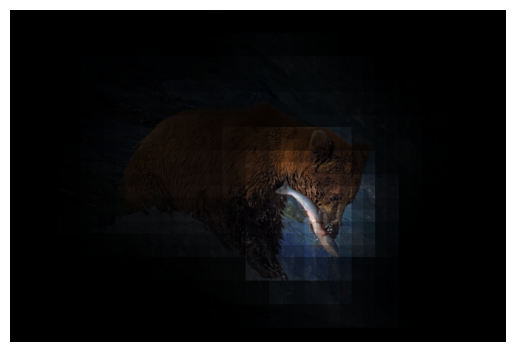

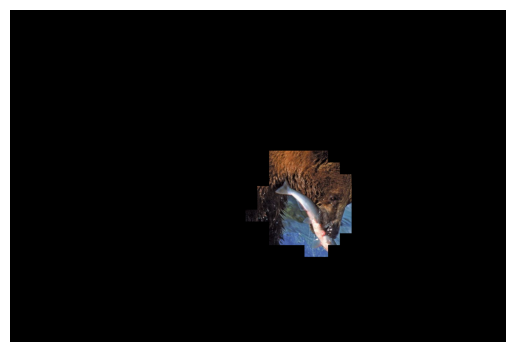

In [44]:
imshow(vis)
imshow(mask.cpu()*img)

## Fun

Enter image URL: https://m.media-amazon.com/images/M/MV5BNmQ0ODBhMjUtNDRhOC00MGQzLTk5MTAtZDliODg5NmU5MjZhXkEyXkFqcGdeQXVyNDUyOTg3Njg@._V1_.jpg
Enter text: a white owl


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


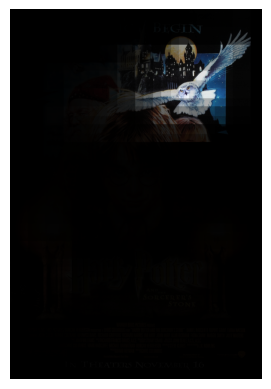

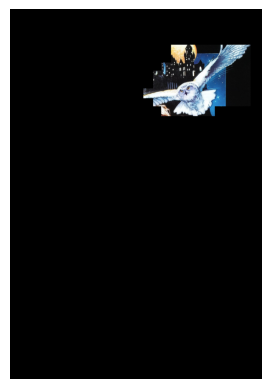

In [47]:
url = input("Enter image URL: ")
text = input("Enter text: ").strip()

test_img = load_img(url)
mask, vis, heatmap = CLIP_segment(test_img.to(device), text)
imshow(vis)
imshow(mask.cpu()*test_img)

Enter image URL: https://www.openaccessgovernment.org/wp-content/uploads/2022/11/hubble_arp248_potw2244a.jpeg
Enter text: a galaxy


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


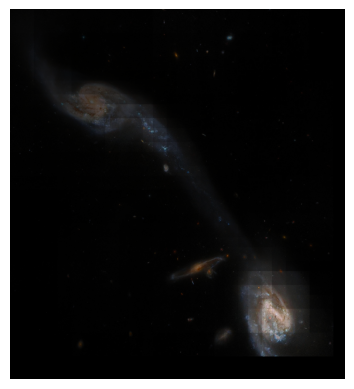

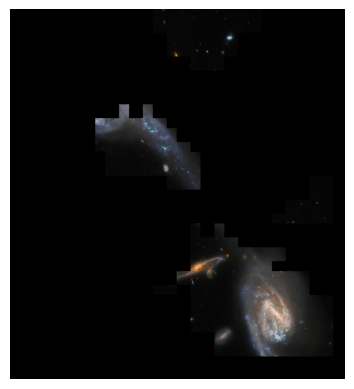

In [57]:
url = input("Enter image URL: ")
text = input("Enter text: ").strip()

test_img = load_img(url)
mask, vis, heatmap = CLIP_segment(test_img.to(device), text, threshold=0.4)
imshow(vis)
imshow(mask.cpu()*test_img)

Enter image URL: https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/202008/iaifi-mit-announcement-00_0.jpg
Enter text: a logo


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


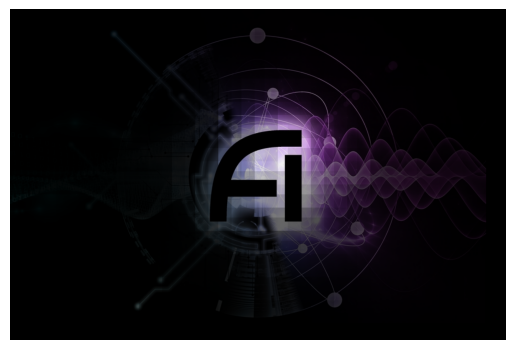

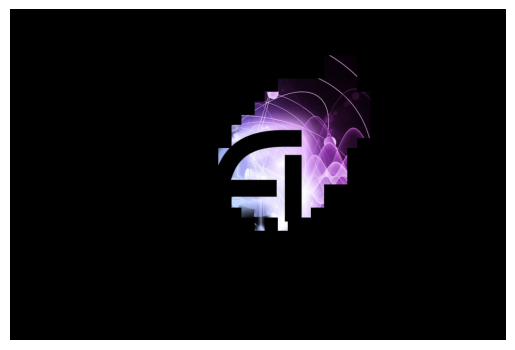

In [55]:
url = input("Enter image URL: ")
text = input("Enter text: ").strip()

test_img = load_img(url)
mask, vis, heatmap = CLIP_segment(test_img.to(device), text)
imshow(vis)
imshow(mask.cpu()*test_img)